In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

plt.style.use('ggplot')

mpl.rcParams['axes.unicode_minus'] = False

In [2]:
train = pd.read_csv('./train.csv', parse_dates=["datetime"])
train.shape

(10886, 12)

In [3]:
test = pd.read_csv('./test.csv', parse_dates=["datetime"])
test.shape

(6493, 9)

## Feature Engineering

In [4]:
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['hour'] = train['datetime'].dt.hour
train['dayofweek'] = train['datetime'].dt.dayofweek
train.shape

(10886, 16)

In [5]:
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['hour'] = test['datetime'].dt.hour
test['dayofweek'] = test['datetime'].dt.dayofweek
test.shape

(6493, 13)

## Feature Selection

In [6]:
categorical_feature_names = ['season', 'holiday', 'workingday', 'weather', 'dayofweek', 'month', 'year', 'hour']

for var in categorical_feature_names:
    train[var] = train[var].astype('category')
    test[var] = test[var].astype('category')

In [7]:
feature_names = ['season', 'weather', 'temp', 'atemp', 'humidity',
                'year', 'hour', 'dayofweek', 'holiday', 'workingday']
feature_names

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [8]:
X_train = train[feature_names]

print(X_train.shape)
X_train.head()

(10886, 10)


,season,weather,temp,atemp,humidity,year,hour,dayofweek,holiday,workingday
0,1,1,9.84,14.395,81,2011,0,5,0,0
1,1,1,9.02,13.635,80,2011,1,5,0,0
2,1,1,9.02,13.635,80,2011,2,5,0,0
3,1,1,9.84,14.395,75,2011,3,5,0,0
4,1,1,9.84,14.395,75,2011,4,5,0,0


In [9]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      10886 non-null  category
 1   weather     10886 non-null  category
 2   temp        10886 non-null  float64 
 3   atemp       10886 non-null  float64 
 4   humidity    10886 non-null  int64   
 5   year        10886 non-null  category
 6   hour        10886 non-null  category
 7   dayofweek   10886 non-null  category
 8   holiday     10886 non-null  category
 9   workingday  10886 non-null  category
dtypes: category(7), float64(2), int64(1)
memory usage: 331.5 KB


In [10]:
X_test = test[feature_names]

print(X_test.shape)
X_test.head()

(6493, 10)


,season,weather,temp,atemp,humidity,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,2011,0,3,0,1
1,1,1,10.66,13.635,56,2011,1,3,0,1
2,1,1,10.66,13.635,56,2011,2,3,0,1
3,1,1,10.66,12.880,56,2011,3,3,0,1
4,1,1,10.66,12.880,56,2011,4,3,0,1


In [11]:
label_name = "count"
y_train = train[label_name]

print(y_train.shape)
y_train.head()

(10886,)


0    16
1    40
2    32
3    13
4     1
Name: count, dtype: int64

In [17]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from datetime import datetime
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

# Any results you write to the current directory are saved as output.

In [60]:
# ################## ML ########################################
print('START ML', datetime.now(), )

kfolds = KFold(n_splits=10, shuffle=True, random_state=42)
X = X_train
y = y_train

# rmsle
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))


# build our model scoring function
def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y,
                                    scoring="neg_mean_squared_error",
                                    cv=kfolds))
    return (rmse)


# setup models    
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

ridge = make_pipeline(RobustScaler(),
                      RidgeCV(alphas=alphas_alt, cv=kfolds))

lasso = make_pipeline(RobustScaler(),
                      LassoCV(max_iter=1e7, alphas=alphas2,
                              random_state=42, cv=kfolds))

elasticnet = make_pipeline(RobustScaler(),
                           ElasticNetCV(max_iter=1e7, alphas=e_alphas,
                                        cv=kfolds, l1_ratio=e_l1ratio))
                                        
svr = make_pipeline(RobustScaler(),
                      SVR(C= 20, epsilon= 0.008, gamma=0.0003,))


gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =42)
                                   

lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       #min_data_in_leaf=2,
                                       #min_sum_hessian_in_leaf=11
                                       )
                                       

xgboost = XGBRegressor(learning_rate=0.01, n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)

from sklearn.ensemble import RandomForestRegressor
rfModel = RandomForestRegressor(n_estimators=100)

# stack
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet,
                                            gbr, lightgbm, rfModel),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)
                                

print('TEST score on CV')

score = cv_rmse(ridge)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(lasso)
print("Lasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(elasticnet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(svr)
print("SVR score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(lightgbm)
print("Lightgbm score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(gbr)
print("GradientBoosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

#score = cv_rmse(xgboost)
#print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )


print('START Fit')
print(datetime.now(), 'StackingCVRegressor')
stack_gen_model = stack_gen.fit(np.array(X_train), np.array(y_train))
print(datetime.now(), 'elasticnet')
elastic_model_full_data = elasticnet.fit(X_train, y_train)
print(datetime.now(), 'lasso')
lasso_model_full_data = lasso.fit(X_train, y_train)
print(datetime.now(), 'ridge')
ridge_model_full_data = ridge.fit(X_train, y_train)
print(datetime.now(), 'svr')
svr_model_full_data = svr.fit(X_train, y_train)
print(datetime.now(), 'GradientBoosting')
gbr_model_full_data = gbr.fit(X_train, y_train)
#print(datetime.now(), 'xgboost')
#xgb_model_full_data = xgboost.fit(X_train, y_train)
print(datetime.now(), 'lightgbm')
lgb_model_full_data = lightgbm.fit(X_train, y_train)
print(datetime.now(), 'RandomForest')
rf_model_full_data = rfModel.fit(X_train, y_train)


START ML 2020-02-23 13:35:40.198727
TEST score on CV
Kernel Ridge score: 141.9702 (2.6142)
 2020-02-23 13:35:45.609101
Lasso score: 141.9756 (2.6131)
 2020-02-23 13:35:46.959063
ElasticNet score: 141.9748 (2.6133)
 2020-02-23 13:35:51.001752
SVR score: 169.6809 (3.9090)
 2020-02-23 13:36:43.178689
Lightgbm score: 67.3670 (1.8747)
 2020-02-23 13:37:04.893101
GradientBoosting score: 41.2230 (1.2030)
 2020-02-23 13:41:28.951422
START Fit
2020-02-23 13:41:28.951762 StackingCVRegressor
[13:44:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
2020-02-23 13:45:50.706379 elasticnet
2020-02-23 13:45:51.081361 lasso
2020-02-23 13:45:51.230729 ridge
2020-02-23 13:45:51.859496 svr
2020-02-23 13:45:58.813457 GradientBoosting
2020-02-23 13:46:34.444167 lightgbm
2020-02-23 13:46:36.841890 RandomForest


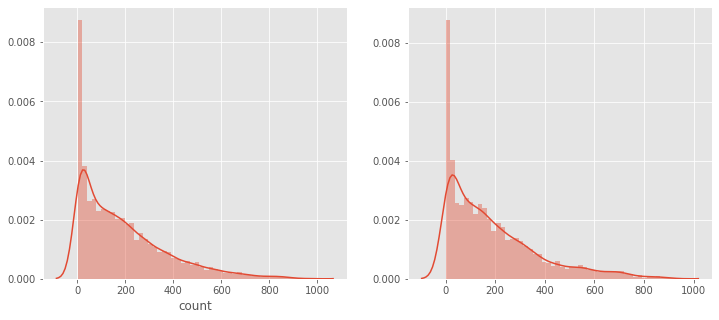

In [62]:
preds = stack_gen.predict(X_test)

fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50)
sns.distplot(preds,ax=ax2,bins=50)

In [63]:
submission = pd.read_csv("./sampleSubmission.csv")


submission["count"] = preds
length = (submission.shape[0])
print(submission.shape[0])
for i in range(length):
    if submission.loc[i,"count"] < 0:
        submission.loc[i,"count"] = 0
    
submission[submission['count']<0]


6493


,datetime,count


In [64]:
submission.to_csv("./stack_gen_submission.csv", index=False)